In [387]:
import typing
import math

import pandas as pd
import numpy as np
import seaborn as sns
import shapely.affinity
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

current_palette = sns.color_palette()
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [388]:
import warnings
warnings.filterwarnings('ignore')

In [389]:
# some parameters
NUM_SENSORS = 100
NUM_LOCATIONS = 200

# maximum distance between sensors to have them considered as in the same group
MAX_SENSOR_GROUP_DIST = 500
# maximum distance from a location to any sensor in a group to consider this group relevant for a sensor
MAX_LOCATION_GROUP_DIST = 1000

# 100 Mbps
DATA_RATE_ISL = 100000
# 88 Kbps for ground to sat
DATA_RATE_GTS = 88

In [390]:
islands = pd.read_csv("islands.csv")
buoys = pd.read_csv("stations.csv")

# buoys["IS_BUOY"] =  buoys["TTYPE"].apply(lambda x: type(x) == str and "BUOY" in x.upper() and not "DRIFT" in x.upper())

ships = pd.read_csv("ships.csv")
ships.rename(columns={"LON": "LONGITUDE", "LAT": "LATITUDE"}, inplace=True)

# only care about ships out at sea
ships = ships[ships["SHIPNAME"] == "[SAT-AIS]"]

In [391]:
pacific_borders = pd.read_csv("./pacific.csv")
# antimeridian (dateline) shenanigans
pacific_polygon = shapely.geometry.Polygon(pacific_borders.values)
pacific_polygon2 = shapely.affinity.translate(pacific_polygon, xoff = 360)

In [392]:
# filter for pacific
islands["IN_PACIFIC"] = islands.apply(lambda x: shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon) or shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon2), axis=1)
ships["IN_PACIFIC"] = ships.apply(lambda x: shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon) or shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon2), axis=1)
buoys["IN_PACIFIC"] = buoys.apply(lambda x: shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon) or  shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon2), axis=1)

In [393]:
# buoys = buoys[(buoys["IN_PACIFIC"] == True) & (buoys["IS_BUOY"] == True)]
buoys = buoys[(buoys["IN_PACIFIC"] == True)]
buoys.reset_index(inplace=True, drop=True)

islands = islands[(islands["IN_PACIFIC"] == True)]
islands.reset_index(inplace=True, drop=True)
islands["STATION_ID"] = ["I" + str(i) for i in range(len(islands))]

ships = ships[(ships["IN_PACIFIC"] == True)]
ships.reset_index(inplace=True, drop=True)
ships["STATION_ID"] = ["S" + str(i) for i in range(len(ships))]

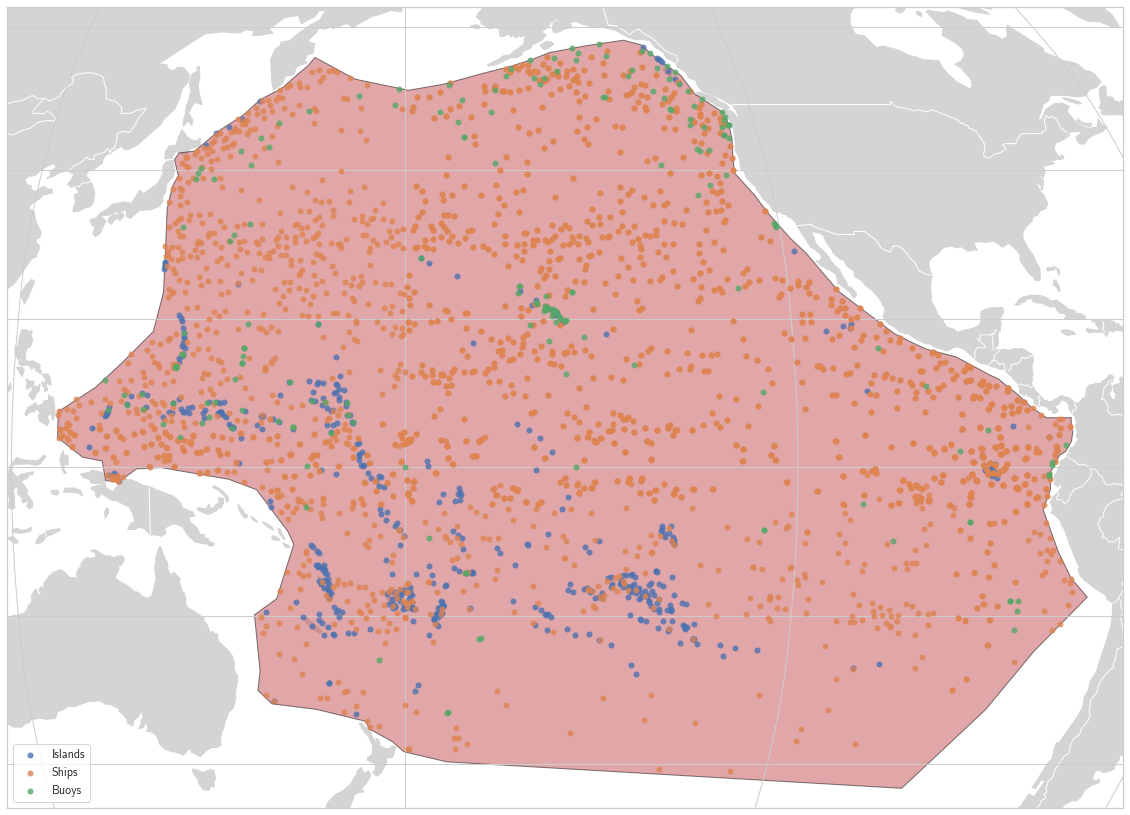

In [394]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=islands, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
sns.scatterplot(ax=ax, data=ships, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
sns.scatterplot(ax=ax, data=buoys, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
ax.add_geometries([pacific_polygon], crs=ccrs.PlateCarree(), facecolor = 'r', edgecolor='black', alpha=0.5)
ax.legend(["Islands", "Ships", "Buoys"], loc="lower left", fontsize=12)

plt.show()

In [395]:
# two buoys are in the same group if they have the same owner and the distance between them is less than 100 km
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

group_id = 1

done = False

buoys["SENSOR_ID"] = range(len(buoys))
buoys["GROUP"] = buoys["SENSOR_ID"]

while not done:
    done = True

    for b1 in range(0,buoys.shape[0]):
        for b2 in range(b1,buoys.shape[0]):
            if b1 != b2:
                if (buoys["OWNER"][b1] == buoys["OWNER"][b2]) and (haversine(buoys["LATITUDE"][b1], buoys["LONGITUDE"][b1], buoys["LATITUDE"][b2], buoys["LONGITUDE"][b2]) < MAX_SENSOR_GROUP_DIST):

                    if buoys["GROUP"][b2] != buoys["GROUP"][b1]:
                        b1_group = buoys["GROUP"][b1]
                        b2_group = buoys["GROUP"][b2]
                        new_group = min(b1_group, b2_group)
                        buoys[(buoys["GROUP"] == b1_group) | (buoys["GROUP"] == b2_group)]["GROUP"] = new_group
                        for b in range(0,buoys.shape[0]):
                            if buoys["GROUP"][b] == b1_group or buoys["GROUP"][b] == b2_group:
                                buoys["GROUP"][b] = new_group
                        done = False


buoys["SENSOR_ID"] = buoys["SENSOR_ID"].astype(int).astype(str)
buoys["GROUP"] = buoys["GROUP"].astype(int).astype(str)

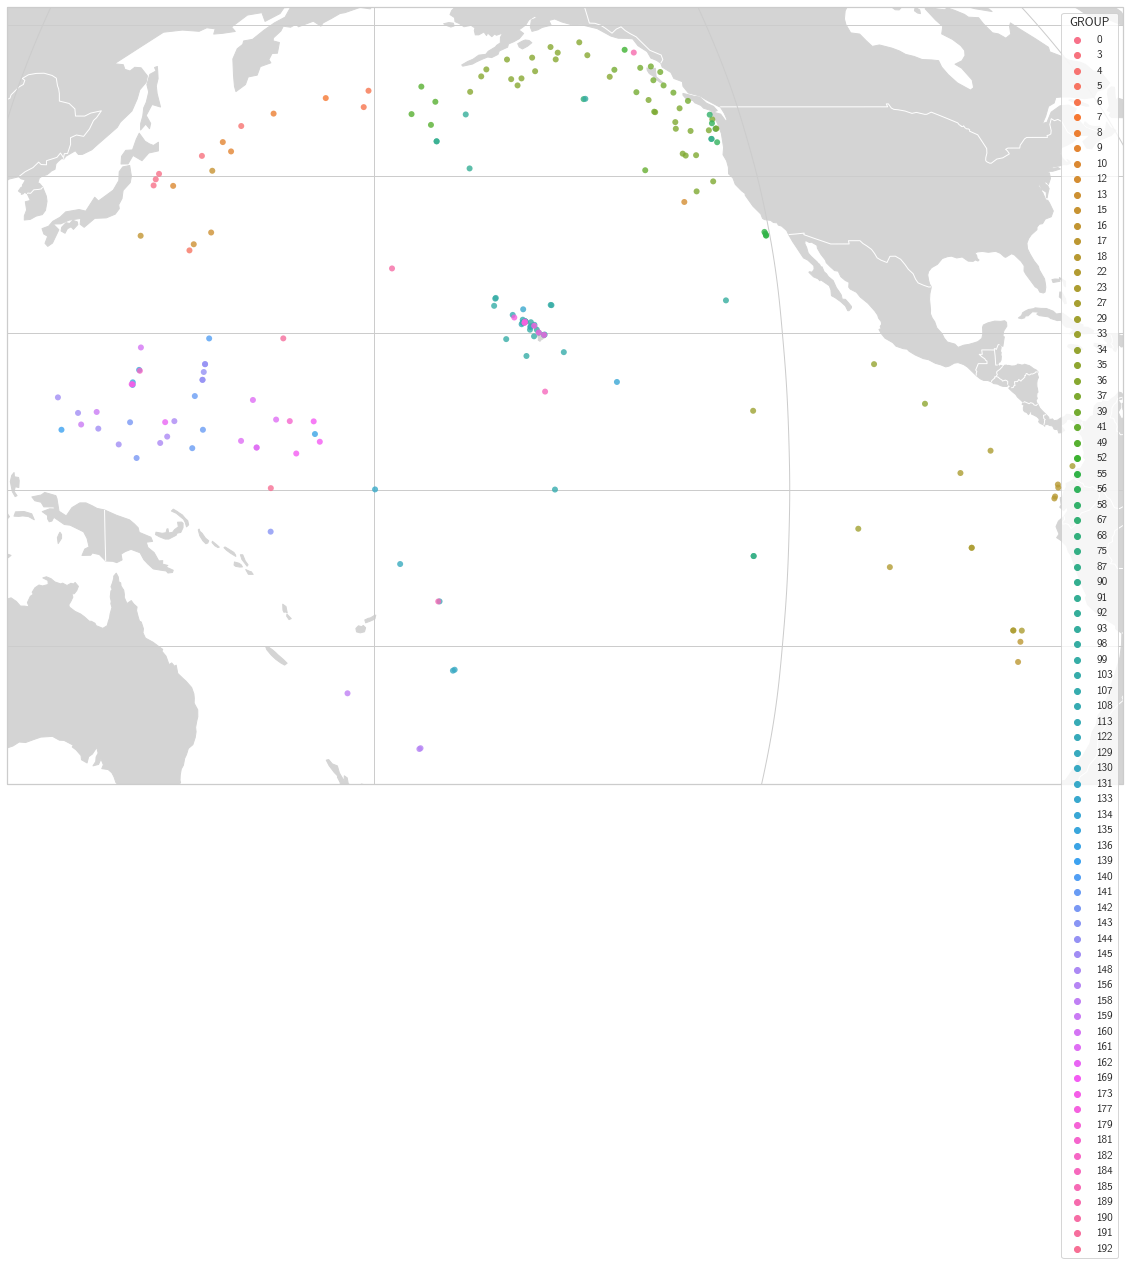

In [396]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8, hue="GROUP")

plt.show()

In [397]:
buoys = buoys[["SENSOR_ID", "GROUP", "LATITUDE", "LONGITUDE"]]

In [398]:
buoys

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE
0,0,0,40.302,146.192
1,1,0,39.601,145.799
2,2,0,38.816,145.595
3,3,3,42.617,152.583
4,4,4,46.488,158.343
...,...,...,...,...
188,188,173,13.428,144.796
189,189,189,56.247,-134.647
190,190,190,28.215,-177.361
191,191,191,19.291,166.618


In [399]:
buoys_to_use = buoys.sample(n=NUM_SENSORS, random_state=0)
buoys_to_use.reset_index(drop=True, inplace=True)
buoys_to_use.head()

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE
0,111,99,24.361,-162.075
1,134,134,13.729,-144.668
2,44,37,48.300,-133.800
3,123,108,21.477,-157.756
4,158,158,-26.000,176.000


In [400]:
# find out island to group affinity
ships["SINK_TYPE"] = "SHIP"
islands["SINK_TYPE"] = "ISLAND"
sinks = pd.concat([islands, ships])
sinks.reset_index(inplace=True)
sink_affinity = pd.DataFrame()

for s in range(0,sinks.shape[0]):
    for b in range(0, buoys_to_use.shape[0]):
        if haversine(sinks["LONGITUDE"][s], sinks["LATITUDE"][s], buoys_to_use["LONGITUDE"][b], buoys_to_use["LATITUDE"][b]) < MAX_LOCATION_GROUP_DIST:
            sink_affinity = sink_affinity.append({"STATION_ID": sinks["STATION_ID"][s], "GROUP": buoys_to_use["GROUP"][b]}, ignore_index=True)

In [401]:
# remove sinks with no affinity
sinks.drop(sinks[sinks["STATION_ID"].isin(sink_affinity["STATION_ID"]) == False].index, inplace=True)

In [402]:
sink_affinity.drop_duplicates(inplace=True)
sink_affinity.reset_index(drop=True, inplace=True)
sink_affinity

,STATION_ID,GROUP
0,I1,158
1,I2,158
2,I3,143
3,I3,192
4,I8,158
...,...,...
5819,S2908,27
5820,S2909,18
5821,S2909,23
5822,S2909,27


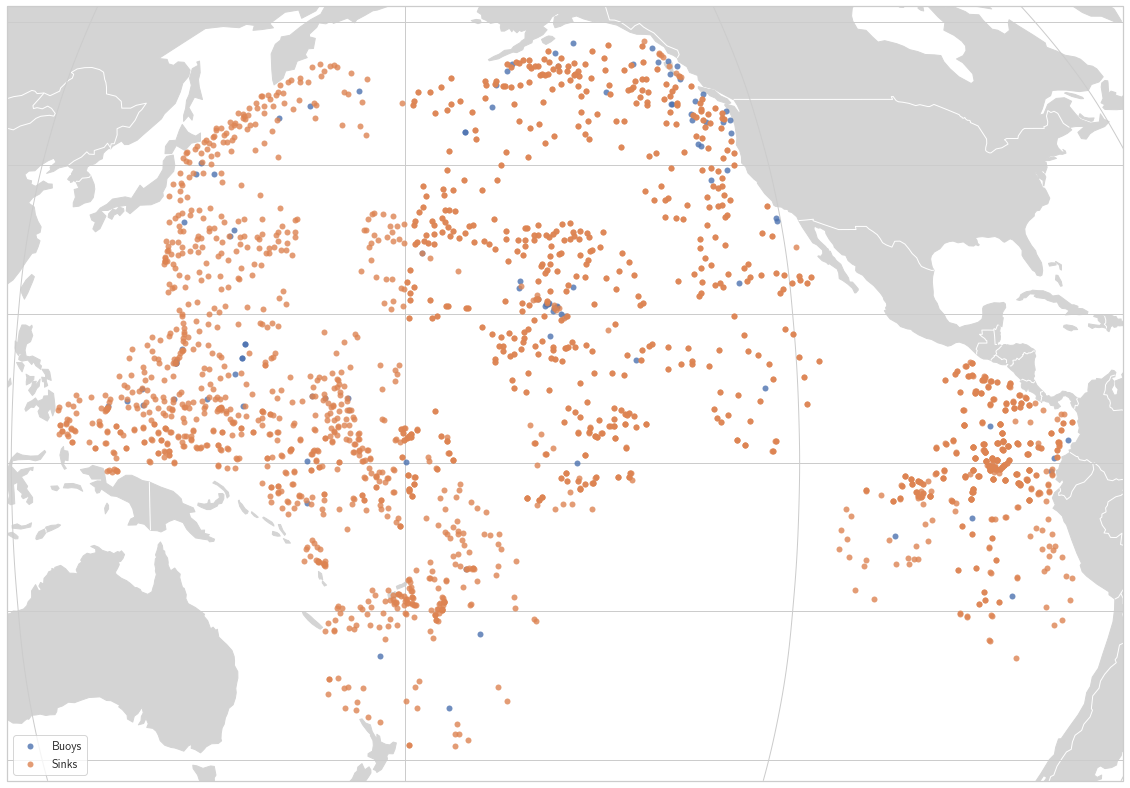

In [403]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
sns.scatterplot(ax=ax, data=sinks, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
ax.legend(["Buoys", "Sinks"], loc="lower left", fontsize=12)

plt.show()

In [404]:
sinks_to_use = sinks.sample(n=NUM_LOCATIONS, random_state=0)
sinks_to_use.reset_index(inplace=True)
sinks_to_use = sinks_to_use[["STATION_ID", "LONGITUDE", "LATITUDE"]]
sinks_to_use.head()

,STATION_ID,LONGITUDE,LATITUDE
0,S358,-88.29912,8.03960
1,S382,-156.09000,31.11182
2,S1620,178.70300,31.74568
3,I314,-165.42000,-11.55000
4,S1208,-146.55270,5.16995


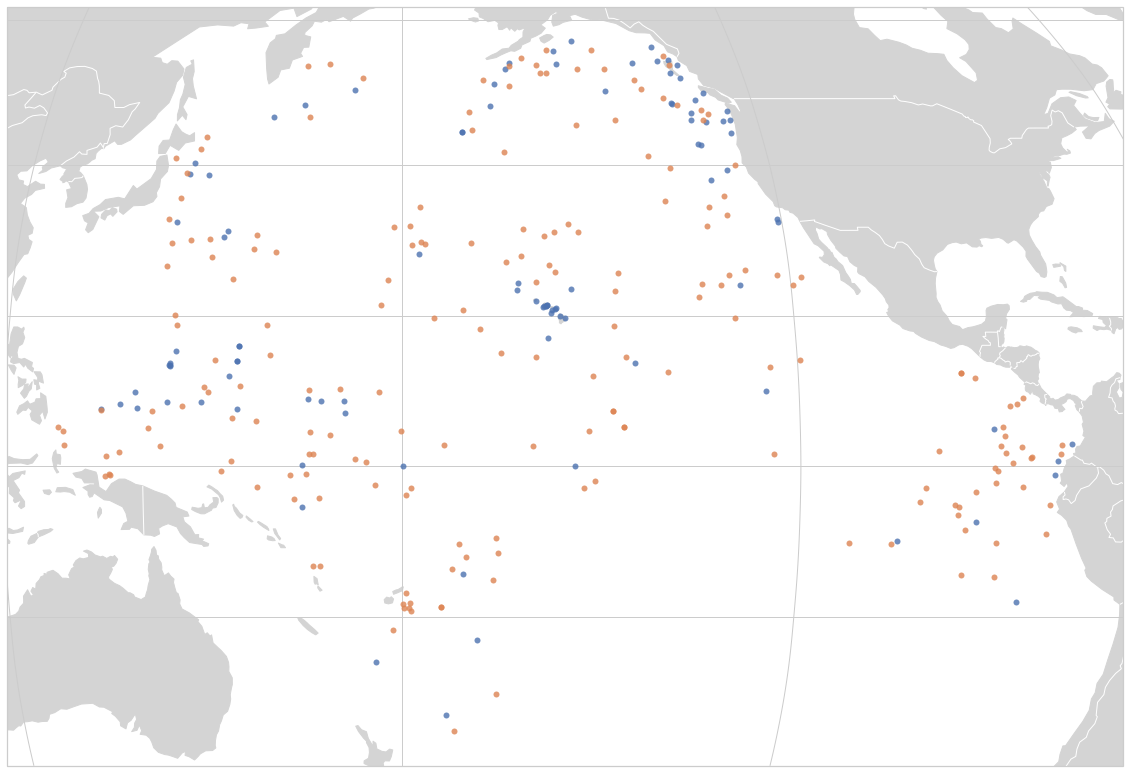

In [405]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)

sns.scatterplot(ax=ax, data=sinks_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)

plt.show()

In [406]:
# create affinity.csv and groups.csv
sink_affinity[sink_affinity["STATION_ID"].isin(sinks_to_use["STATION_ID"])].to_csv("affinity.csv", index=False)

buoys_to_use[["SENSOR_ID", "GROUP"]].to_csv("groups.csv", index=False)

In [407]:
# join buoy, ship, and island dataframes to get list of all locations and add a column for type of location
buoys_to_use["LOCATION_TYPE"] = "BUOY"
sinks_to_use["LOCATION_TYPE"] = "SINK"
all_locations = pd.concat([buoys_to_use, sinks_to_use])
all_locations.reset_index(drop=True, inplace=True)

all_locations.head()

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE,LOCATION_TYPE,STATION_ID
0,111,99,24.361,-162.075,BUOY,NaN
1,134,134,13.729,-144.668,BUOY,NaN
2,44,37,48.300,-133.800,BUOY,NaN
3,123,108,21.477,-157.756,BUOY,NaN
4,158,158,-26.000,176.000,BUOY,NaN


In [408]:
sinks_to_use.head()

,STATION_ID,LONGITUDE,LATITUDE,LOCATION_TYPE
0,S358,-88.29912,8.03960,SINK
1,S382,-156.09000,31.11182,SINK
2,S1620,178.70300,31.74568,SINK
3,I314,-165.42000,-11.55000,SINK
4,S1208,-146.55270,5.16995,SINK


In [409]:
grouped_locations = sinks_to_use.merge(sink_affinity, on="STATION_ID", how="inner")
grouped_locations.head()

,STATION_ID,LONGITUDE,LATITUDE,LOCATION_TYPE,GROUP
0,S358,-88.29912,8.03960,SINK,23
1,S382,-156.09000,31.11182,SINK,99
2,S1620,178.70300,31.74568,SINK,190
3,I314,-165.42000,-11.55000,SINK,185
4,S1208,-146.55270,5.16995,SINK,134


In [410]:
grouped_locations["GROUP"].unique()

array(['23', '99', '190', '185', '134', '107', '36', '90', '92', '108',
       '179', '113', '177', '37', '39', '98', '189', '130', '131', '5',
       '16', '13', '181', '169', '161', '192', '136', '0', '10', '143',
       '144', '173', '141', '135', '142', '162', '55', '93', '7', '8',
       '56', '139', '18', '27', '145', '159', '22', '156', '4', '158',
       '33'], dtype=object)

In [411]:
total_groups = grouped_locations.merge(buoys_to_use, on="GROUP", how="inner")
total_groups

,STATION_ID,LONGITUDE_x,LATITUDE_x,LOCATION_TYPE_x,GROUP,SENSOR_ID,LATITUDE_y,LONGITUDE_y,LOCATION_TYPE_y
0,S358,-88.29912,8.039600,SINK,23,26,-7.428,-93.480,BUOY
1,S358,-88.29912,8.039600,SINK,23,24,4.958,-90.868,BUOY
2,S358,-88.29912,8.039600,SINK,23,30,-17.980,-86.330,BUOY
3,S2327,-99.25500,2.031667,SINK,23,26,-7.428,-93.480,BUOY
4,S2327,-99.25500,2.031667,SINK,23,24,4.958,-90.868,BUOY
...,...,...,...,...,...,...,...,...,...
1162,I44,-178.92000,-18.830000,SINK,158,158,-26.000,176.000,BUOY
1163,S2492,-179.64730,-18.883480,SINK,158,158,-26.000,176.000,BUOY
1164,S38,-124.21070,13.223470,SINK,33,33,10.051,-125.032,BUOY
1165,S1317,-119.60100,14.152110,SINK,33,33,10.051,-125.032,BUOY


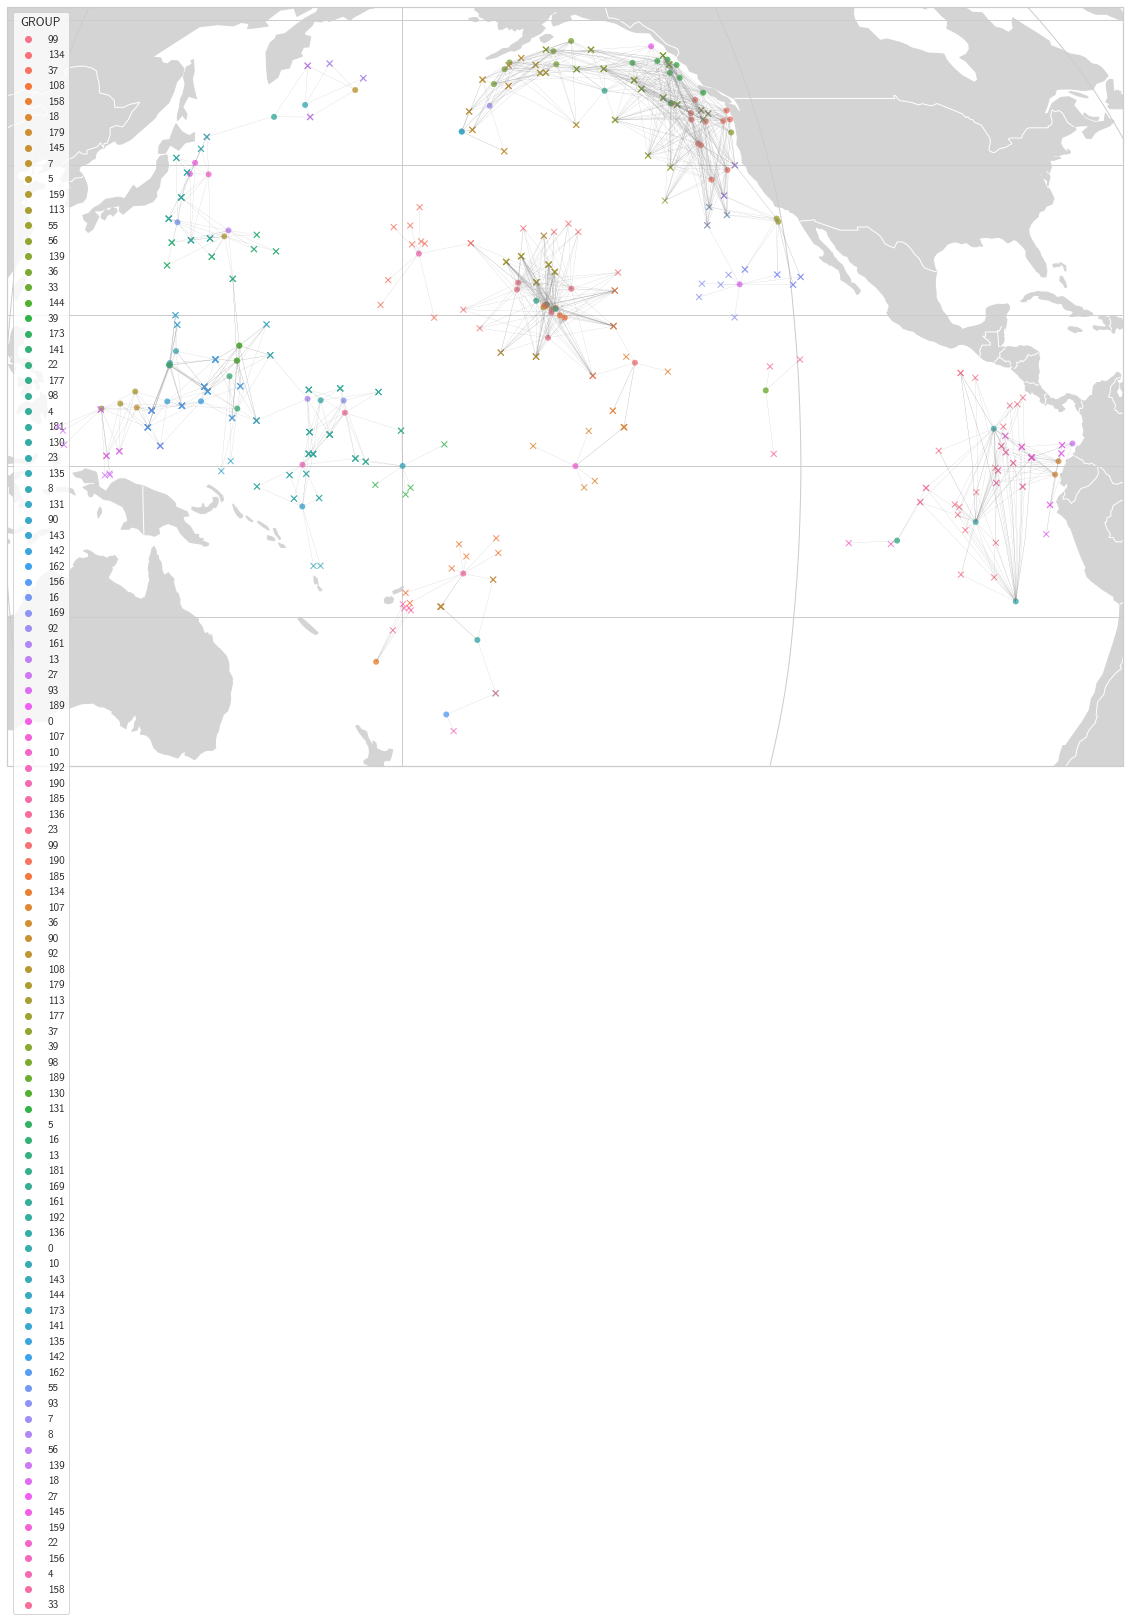

In [424]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.Geodetic(), zorder=10, linewidth=0, alpha=0.8, hue="GROUP")
sns.scatterplot(ax=ax, data=grouped_locations, x="LONGITUDE", y="LATITUDE", transform=ccrs.Geodetic(), zorder=10, linewidth=1, alpha=0.8, hue="GROUP", marker="x")

for g in range(total_groups.shape[0]):
    ax.plot([total_groups["LONGITUDE_x"][g], total_groups["LONGITUDE_y"][g]], [total_groups["LATITUDE_x"][g], total_groups["LATITUDE_y"][g]], linewidth=0.1, color="gray", markersize=1, zorder=10, transform=ccrs.Geodetic())

plt.show()

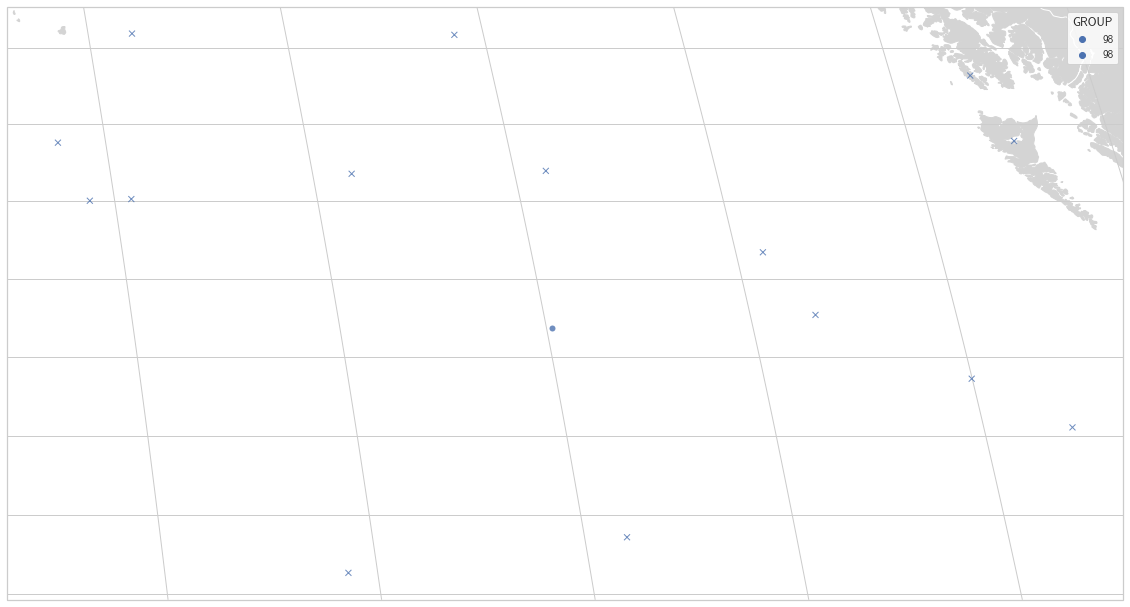

In [413]:
GROUP = "98"

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys_to_use[buoys_to_use["GROUP"] == GROUP], x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8, hue="GROUP")
sns.scatterplot(ax=ax, data=grouped_locations[grouped_locations["GROUP"] == GROUP], x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=1, alpha=0.8, hue="GROUP", marker="x")

plt.show()

In [414]:
EARTH_RADIUS = 6371000
def sat_dist(altitude: float, elevation: float) -> float:
    A = EARTH_RADIUS
    B = EARTH_RADIUS + altitude * 1000
    b = np.radians(90.0 + elevation)
    a = np.arcsin(A * np.sin(b) / B)
    c = np.radians(180) - a - b

    return float(2.0 * np.pi * EARTH_RADIUS * c/np.radians(360.0))

# max sat distance in iridium:
max_dist = sat_dist(altitude=780, elevation=8.2)

In [415]:
# old bbox
l_lat = pacific_borders.min()["LATITUDE"]
l_lng = pacific_borders.min()["LONGITUDE"]
r_lat = pacific_borders.max()["LATITUDE"]
r_lng = pacific_borders.max()["LONGITUDE"]

# offset latitudes by max distance
# https://stackoverflow.com/questions/2839533/adding-distance-to-a-gps-coordinate

l_lat_new = l_lat - (180/np.pi)*(max_dist/EARTH_RADIUS)
l_lng_new = l_lng - (180/np.pi)*(max_dist/EARTH_RADIUS) * np.cos(np.radians(l_lat))
r_lat_new = r_lat + (180/np.pi)*(max_dist/EARTH_RADIUS)
r_lng_new = r_lng + (180/np.pi)*(max_dist/EARTH_RADIUS) * np.cos(np.radians(r_lat))

bbox_polygon = shapely.geometry.Polygon([[l_lng, l_lat], [l_lng, r_lat], [r_lng, r_lat], [r_lng, l_lat]])
bbox_polygon_new = shapely.geometry.Polygon([[l_lng_new, l_lat_new], [l_lng_new, r_lat_new], [r_lng_new, r_lat_new], [r_lng_new, l_lat_new]])

print(f"""
old bbox:
l_lat: {l_lat}
l_lng: {l_lng}
r_lat: {r_lat}
r_lng: {r_lng}

new bbox:
l_lat: {l_lat_new}
l_lng: {l_lng_new}
r_lat: {r_lat_new}
r_lng: {r_lng_new}
""")


old bbox:
l_lat: -43.259706
l_lng: -233.0859375
r_lat: 58.2021939
r_lng: -74.5388889

new bbox:
l_lat: -63.19752906550502
l_lng: -247.6057546094728
r_lat: 78.14001696550503
r_lng: -64.03318633137593



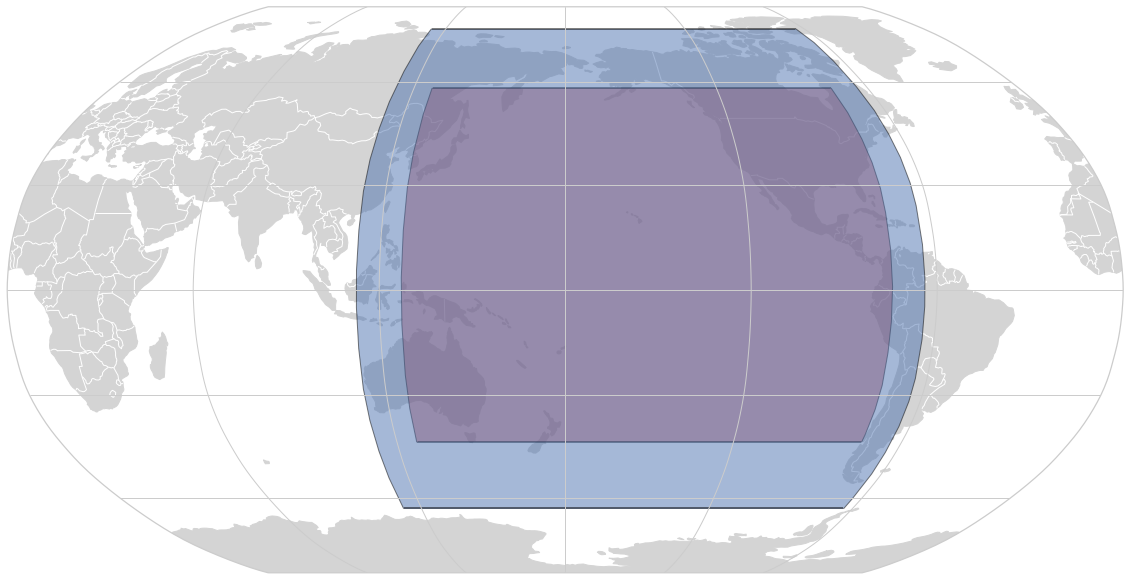

In [416]:
cmap = sns.color_palette("viridis", as_cmap=True)

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()
ax.add_geometries([bbox_polygon], crs=ccrs.PlateCarree(), facecolor = 'r', edgecolor='black', alpha=0.5)
ax.add_geometries([bbox_polygon_new], crs=ccrs.PlateCarree(), facecolor = 'b', edgecolor='black', alpha=0.5)
plt.show()

In [417]:
# bounding box
print(f'[{l_lat_new}, {l_lng_new + 360}, {r_lat_new}, {r_lng_new}]')

[-63.19752906550502, 112.3942453905272, 78.14001696550503, -64.03318633137593]


In [418]:
all_locations.head()

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE,LOCATION_TYPE,STATION_ID
0,111,99,24.361,-162.075,BUOY,NaN
1,134,134,13.729,-144.668,BUOY,NaN
2,44,37,48.300,-133.800,BUOY,NaN
3,123,108,21.477,-157.756,BUOY,NaN
4,158,158,-26.000,176.000,BUOY,NaN


In [419]:
bbox = {
    "lon1": l_lng_new + 360,
    "lat1": l_lat_new,
    "lon2": r_lng_new,
    "lat2": r_lat_new
}

def is_in_bbox(lon: float, lat:float) -> bool:

    # check if lat long is in bounding box
    if bbox["lon2"] < bbox["lon1"]:
        if lon < bbox["lon1"] and lon > bbox["lon2"]:
            return False
    else:
        if lon < bbox["lon1"] or lon > bbox["lon2"]:
            return False

    return bool(lat >= bbox["lat1"] and lat <= bbox["lat2"])

all_locations["IN_BBOX"] = all_locations.apply(lambda row: is_in_bbox(row["LONGITUDE"], row["LATITUDE"]), axis=1)

In [420]:
len(all_locations[all_locations["IN_BBOX"] == False])

0

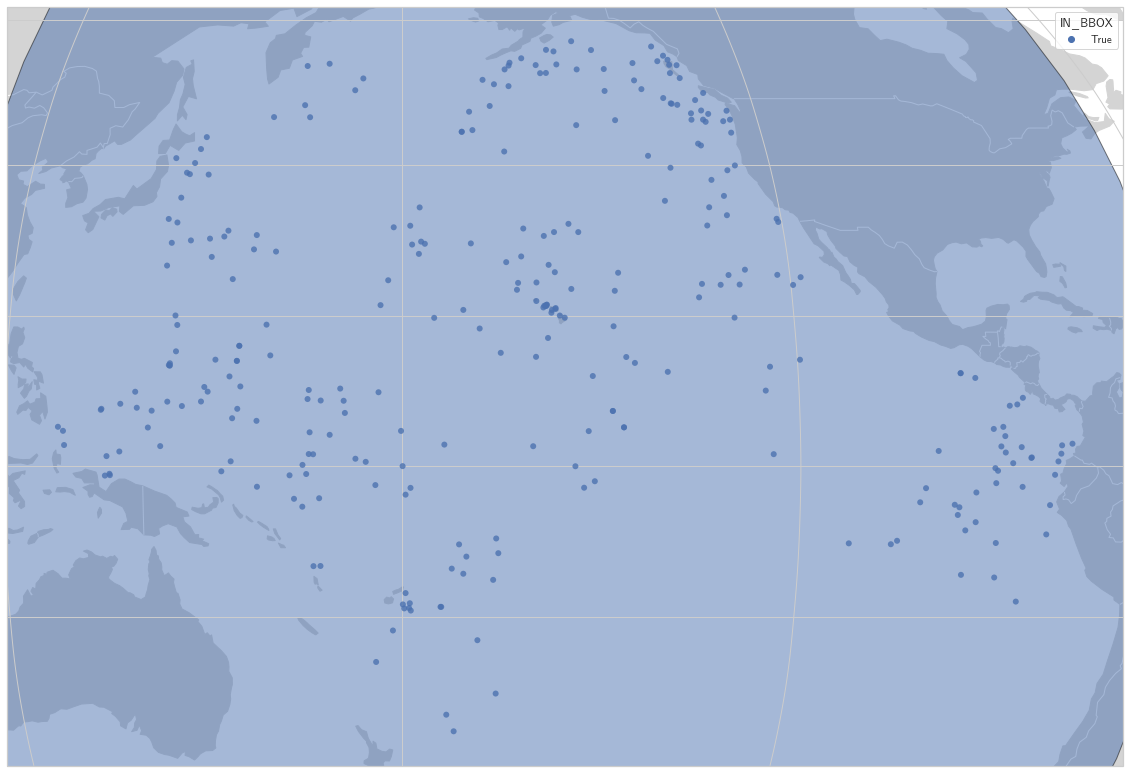

In [421]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=all_locations, transform=ccrs.PlateCarree(), y="LATITUDE", x="LONGITUDE", zorder=10, linewidth=0, alpha=0.8, hue="IN_BBOX")
ax.add_geometries([bbox_polygon_new], crs=ccrs.PlateCarree(), facecolor = 'b', edgecolor='black', alpha=0.5)

plt.show()

In [422]:
# create the toml

with open("iridium-full.toml", "w") as f:

    f.write(f"""model = "SGP4"

bbox = [{l_lat_new}, {l_lng_new + 360}, {r_lat_new}, {r_lng_new}]
interval = 5
animation = false
hosts = ["192.168.0.6:1969", "192.168.0.7:1969", "192.168.0.8:1969", "192.168.0.9:1969"]
peeringhosts = ["192.168.0.6:1970", "192.168.0.7:1970", "192.168.0.8:1970", "192.168.0.9:1970"]
dbhost = "192.168.0.2:8000"
database = true

[networkparams]
islpropagation = 3.336e-6
bandwidth = {DATA_RATE_GTS}
mincommsaltitude = 100_000
minelevation = 8.2
gstpropagation = 3.336e-6
groundstationconnectiontype = "shortest"

[computeparams]
vcpu_count = 1
mem_size_mib = 1024
ht_enabled = false
bootparams = ""
kernel = "vmlinux.bin"
rootfs = "service.img"
disk_size_mib = 100

[sgp4params]
starttime = 2022-01-01T12:00:00+00:00

[[shell]]
planes = 6
sats = 11
altitude = 780
inclination = 90.0
arcofascendingnodes = 180.0
eccentricity = 0.0

[shell.networkparams]
bandwidth = {DATA_RATE_ISL}

""")
    with open("locations.csv", "w") as c_f:
        c_f.write("id,type,lat,lng\n")
    
        for index, row in all_locations.iterrows():
            if row["LOCATION_TYPE"] == "BUOY":
                c_f.write(f"{row['SENSOR_ID']},sensor,{row['LATITUDE']},{row['LONGITUDE']}\n")

                f.write(f"""
[[groundstation]]
name = "sensor{row['SENSOR_ID']}"
lat = {row['LATITUDE']}
long = {row['LONGITUDE']}

[groundstation.computeparams]
rootfs = "sensor.img"

""")

                continue
            else:
                c_f.write(f"{row['STATION_ID']},sink,{row['LATITUDE']},{row['LONGITUDE']}\n")
                f.write(f"""
[[groundstation]]
name = "sink{row['STATION_ID']}"
lat = {row['LATITUDE']}
long = {row['LONGITUDE']}

[groundstation.computeparams]
rootfs = "sink.img"

""")

                continue